# Lecture 12: Neural Networks (continued)

We have seen a few implementations of neural networks in [lecture 11](https://github.com/kaygun/18-Fall-Math388E/tree/master/lecture-11) and I did a detailed treatment of [perceptrons](https://www.cs.cmu.edu/afs/cs.cmu.edu/academic/class/15381-f01/www/handouts/110601.pdf) (these are the building blocks of neural networks) in [lecture 10](https://github.com/kaygun/18-Fall-Math388E/tree/master/lecture-10).  Today, I will dig deeper into neural networks and how they work:

Let us start with a simple example: assume we have a neural network with a 6 dimensional input, two hidden layers one with 4 nodes and next with 3 node, and finally a 1 dimensional output layer.

![example neural network](images/example-network.png)

(Source: [Computer Science Wiki](https://computersciencewiki.org/index.php/Multi-layer_perceptron_(MLP)))

If we label inputs as $(x_1,\ldots,x_6)$ then the computation for outputs $(y_1,\ldots,y_4)$ for the first layer would be given by 

$$ y_j = \sigma\left(\sum_{i=1}^6 w^1_{ji} x_i\right) $$

where $\sigma$ refers to the activation function of the nodes labelled by $j=1,2,3,4$. For simplicity, we assume all perceptrons have the same activation function $\sigma$.  And the numbers $w^1_{ij}$ refer to the weights associated with each connection between $x_i$ and $y_j$ for $i=1,\ldots,6$ and $j=1,\ldots,4$.

Passing from layer 1 to layer 2, the computation follows

$$ z_k = \sigma\left(\sum_{j=1}^4 w^2_{kj} y_j\right) $$

Again, the numbers $w^2_{kj}$ (this is **NOT** a square) refer to the weights associated with each connection between $y_j$ and $z_k$ for $j=1,\ldots,4$ and $k=1,2,3$.

And the for final output layer we have

$$ out = \sigma\left(\sum_{k=1}^3 w^3_{k} z_k \right) $$

Notice that the computation resembles matrix multiplication, and if we did not have the activation function, this is just a sequence of matrix multiplications.  The activation function provides us a crutial non-linearity and allows us to model non-linear function, not just linear ones.

I have shown you several examples of such networks and their presentation in [keras](https://keras.io/) in the previous lecture.  Following those examples, we would implement such a network as follows:

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Activation, MaxPooling2D, Flatten

Using TensorFlow backend.


In [2]:
model = Sequential()
model.add(Dense(4, input_shape=(6,), activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dense(1, activation='tanh'))

Here we used the same activation function $tanh(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}}$.

The phase of the computation from input layer to the output layer is called *feed-forward*. In the feed-forward phase we assume we have the correct weights for the connections between the nodes.  However, the output we get and the target value we needed to produce may not be the same. So, we need to adjust the weights $w^\ell_{ij}$ in such a way that the difference between the targeted output and actual ouput is narrowed.  This procedure is called *back-propagation*.

I explained in [lecture 10](https://github.com/kaygun/18-Fall-Math388E/blob/master/lecture-10/lecture-10.ipynb) how back-propagation works.

When we train the network, we feed-forward and input $(x_1,\ldots,x_6)$ and then calculate $\delta$ the difference between the result of the feed-forward operation and the targeted output.  Then we back-propagate this $\delta$ over the network. Then we move onto the next input, and repeat.

I showed several examples of these steps in [lecture 11](https://github.com/kaygun/18-Fall-Math388E/tree/master/lecture-11).


In practice, the input dimension can be very large and the number of layers can also be large.  Here we used a very simple network topology where every node on each layer are connected.  Such networks are called *fully connected*.  Also, in this example, there is no [dropout](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf) or [recurrence](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) or [convolution](http://deeplearning.stanford.edu/tutorial/supervised/ConvolutionalNeuralNetwork/).

There is [a large number](http://www.asimovinstitute.org/neural-network-zoo/) of different topologies and different types of perceptrons.  Please check [this link](http://www.asimovinstitute.org/neural-network-zoo/) to acquaint yourselves with these different options.

Today, I am going to go over two such variations:

## Convolutional networks

[Convolution](https://en.wikipedia.org/wiki/Convolution) is a binary operation between two functions that crates a third function that resembles both of the input functions. 

![convolution](images/convolution.gif)

(Source: [Wikipedia](https://en.wikipedia.org/wiki/Convolution))

The main idea is that if one of these function is badly behaved (such as discontinuous, or non-differentiable) and the other is nice (continuous, differentiable, smooth) the resulting function imparts the shape of the original bad function, and the *niceness* properties of the second function.

[Convolutional networks](http://cs231n.github.io/convolutional-networks/) use this idea but they use a [discrete multivariate version](https://en.wikipedia.org/wiki/Multidimensional_discrete_convolution): their inputs are discrete sequences (or arrays, or tensors)

$$ (x*y)_t = \sum_{i=1}^n x_{t-i} y_i $$

Instead of using the summation operation, one can use *max* operation $x\vee y = \max(x,y)$ which is both unital (if the inputs are positive) and associative

$$ (x\vee 0) = (0\vee x) = x \qquad x\vee (y\vee z) = (x\vee y) \vee z $$

Then we get another type of a convolution

$$ (x*y)_t =\bigvee_{i=1}^n x_{t-i} y_i $$

which is also called *max-pooling*.  


One of the places where discrete convolution operation is used is in [image processing](https://en.wikipedia.org/wiki/Kernel_(image_processing)).  So, it is not a big surprise that [convolutional networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) are also used in image processing and image classification tasks.

Today, we are going to build a convolutional neural network in keras to identify faces. We are going to use [the Olivetti dataset of faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html) from [scikit-learn](https://scikit-learn.org/stable/index.html).

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn import datasets
from sklearn.model_selection import train_test_split
faces = datasets.fetch_olivetti_faces(data_home="data")

OK. We fetched the data. Now, let us see few random faces. Not that we need it, but just for fun.

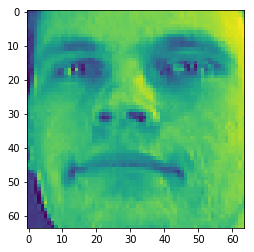

In [4]:
N = len(faces.images)
plt.imshow(faces.images[np.random.randint(N)])

Each picture has size 64x64 pixels, each pixel value ranges between 0 and 1: 0 indicating black and 1.0 indicating bright white with various levels of grays in between:

In [5]:
print(faces.images[1])
print(faces.images[1].shape)

[[0.45454547 0.47107437 0.5123967  ... 0.19008264 0.18595041 0.18595041]
 [0.446281   0.48347107 0.5206612  ... 0.21487603 0.2107438  0.2107438 ]
 [0.49586776 0.5165289  0.53305787 ... 0.20247933 0.20661157 0.20661157]
 ...
 [0.77272725 0.78099173 0.7933884  ... 0.1446281  0.1446281  0.1446281 ]
 [0.77272725 0.7768595  0.7892562  ... 0.13636364 0.13636364 0.13636364]
 [0.7644628  0.7892562  0.78099173 ... 0.15289256 0.15289256 0.15289256]]
(64, 64)


The array `faces.target` identifies each image with a spefic person. There are 40 different individual and each individual has 10 pictures each.  Since we need to write one classifier for each individual, these integers has to be converted into 40 dimensional vectors each containing all 0's and one 1 indicating which individual is targeted with that vector:

In [6]:
print(faces.target)
ys = keras.utils.to_categorical(faces.target)
print(ys)

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31
 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32

Our task is to build a convolutional network that will predict these labels from the pictures, i.e. we are going to build a function that takes a picture as an input and produces an integer between 0 and 39 (inclusive) identifying that individual.

First, we are going to split the data into a test and train sets. 

In [7]:
x_train, x_test, y_train, y_test = train_test_split(faces.data, ys, test_size=0.25)

Let us start building our network: first layer has 64x64 = 4096 dimensional input. I am going to make our first layer a big convolutional one (with 128 nodes) with a kernel of size 4x4-pixels, and with $tanh(x)$ as the activation function:

In [8]:
model = Sequential()
model.add(Conv2D(128, (4,4), input_shape=(64,64,1,), activation='tanh'))

Next, let us add a fully connected layer with a dropout rate of 25%

In [9]:
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))

Next, let us add a max-pooling filter to this layer

In [10]:
model.add(MaxPooling2D(pool_size=(3,3)))

We are going to flatten the image and then send it to the output layer.

In [11]:
model.add(Flatten())
model.add(Dense(40, activation='sigmoid'))

Now, let us compile the model and then train it:

In [14]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='RMSProp')
model.fit(x_train.reshape(300,64,64,1), y_train, batch_size=32, epochs=12)

Epoch 1/12
300/300 [==============================] - 4s 12ms/step - loss: 0.7907 - acc: 0.8433
Epoch 2/12
300/300 [==============================] - 4s 12ms/step - loss: 0.0211 - acc: 1.0000
Epoch 3/12
300/300 [==============================] - 4s 12ms/step - loss: 0.0101 - acc: 1.0000
Epoch 4/12
300/300 [==============================] - 4s 12ms/step - loss: 0.0058 - acc: 1.0000
Epoch 5/12
300/300 [==============================] - 4s 12ms/step - loss: 0.0040 - acc: 1.0000
Epoch 6/12
300/300 [==============================] - 4s 12ms/step - loss: 0.0022 - acc: 1.0000
Epoch 7/12
300/300 [==============================] - 4s 12ms/step - loss: 0.0014 - acc: 1.0000
Epoch 8/12
300/300 [==============================] - 4s 12ms/step - loss: 0.0920 - acc: 0.9800
Epoch 9/12
300/300 [==============================] - 4s 12ms/step - loss: 0.0019 - acc: 1.0000
Epoch 10/12
300/300 [==============================] - 4s 12ms/step - loss: 9.4143e-04 - acc: 1.0000
Epoch 11/12
300/300 [==============

In [15]:
result = model.evaluate(x_test.reshape(100,64,64,1), y_test, batch_size=32, verbose=1)
result

100/100 [==============================] - 0s 3ms/step


[0.2766281354427338, 0.93]